# Notebook to debug VOC2012 dataset and the model

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys

here_path = Path(".").resolve()
os.environ["VOC_ROOT"] = "/home/storage_ext4_1tb/VOCdevkit/"
sys.path.insert(0, (here_path / ".." / ".." / ".." ).resolve().as_posix())
sys.path.insert(0, (here_path / ".." ).resolve().as_posix())
sys.path.insert(0, "/home/working_directory/ml/VisionTransforms/")

In [3]:
voc_root_var = "VOC_ROOT" if "VOC_ROOT" in os.environ else "VOC_DIR"
voc_root_path = Path(os.environ[voc_root_var])

assert voc_root_path.exists(), "Path '{}' is not found".format(voc_root_path)

In [4]:
from datasets import VOCDetection, TransformedDataset, to_target, VOC_CLASSES

In [5]:
path = voc_root_path / "VOC2012"

voc_train_ds = VOCDetection(path, "train")
voc_val_ds = VOCDetection(path, "val")
len(voc_train_ds), len(voc_val_ds)

(5717, 5823)

In [6]:
type(voc_train_ds[0][0]), voc_train_ds[0][1]

(numpy.ndarray,
 [([52, 86, 470, 419],
   'horse',
   {'is_difficult': False, 'is_occluded': True, 'is_truncated': False}),
  ([157, 43, 288, 166],
   'person',
   {'is_difficult': False, 'is_occluded': False, 'is_truncated': True})])

In [7]:
train_ds = TransformedDataset(voc_train_ds, xy_transform=to_target)
val_ds = TransformedDataset(voc_val_ds, xy_transform=to_target)

In [8]:
train_ds[0][1]

[(array([ 52,  86, 470, 419]), 12), (array([157,  43, 288, 166]), 14)]

In [9]:
import matplotlib.pylab as plt

%matplotlib inline

In [10]:
img, target = train_ds[0]
img.shape, img.dtype, type(img), type(target)

((442, 500, 3), dtype('uint8'), numpy.ndarray, list)

In [11]:
import numpy as np 

from image_dataset_viz import render_datapoint, bbox_to_points


def get_vis_target(targets):    
    out = []
    for t, l in target:
        out.append((bbox_to_points(t), "{}".format(l)))
    return out

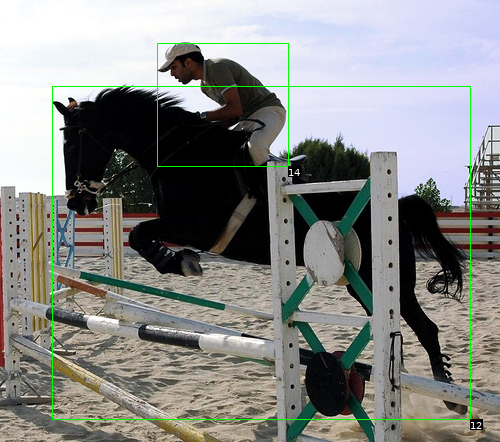

In [12]:
from image_dataset_viz import render_datapoint, bbox_to_points

vis_target = get_vis_target(target)

# vis_target
render_datapoint(img, vis_target)

(500, 375, 3) uint8


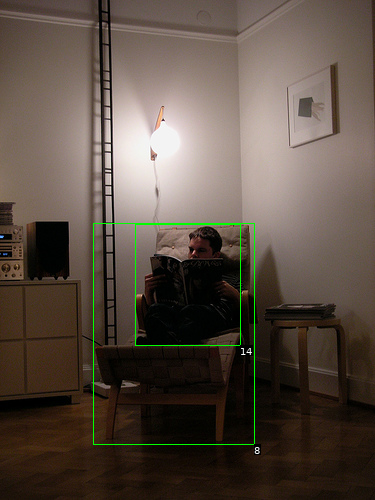

In [13]:
img, target = val_ds[20]
print(img.shape, img.dtype)


vis_target = get_vis_target(target)

# vis_target
render_datapoint(img, vis_target)

Transforms for the training

In [14]:
import numpy as np
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


import vision_transforms as vt
vt.set_image_backend("opencv")


class DataAugTransform(vt.BaseTransform):
    
    def __init__(self):
        
        translate_scale_params = {
            'translate': (0.2, 0.2),
            'scale': (0.7, 1.3)
        }
        self.random_affine = vt.RandomAffine(degrees=0, **translate_scale_params, resample=cv2.INTER_CUBIC)
        self.bbox_random_affine = vt.BBoxRandomAffine(**translate_scale_params)
        
        self.random_crop = vt.RandomCrop(size=300, padding=50)
        self.bbox_random_crop = vt.BBoxRandomCrop(size=300, padding=50)
        
        self.img_geom = vt.Sequential(
            self.random_affine,
            self.random_crop,
        )
        self.bbox_geom = vt.Sequential(
            self.bbox_random_affine,
            self.bbox_random_crop,
        )        
        self.img_color = vt.ColorJitter(hue=0.1, saturation=0.2)
        
    def __call__(self, datapoint, rng):
        
        x, y = datapoint
        img_rgb = x
        bboxes, labels = list(zip(*y))
        bboxes = np.array(bboxes)

        t_img_rgb = self.img_geom(img_rgb, rng)
        t_img_rgb = self.img_color(t_img_rgb)
        t_bboxes = self.bbox_geom(bboxes, rng, input_canvas_size=img_rgb.shape[:2])    
        
        # to CHW normalized float32:
        x = np.transpose(t_img_rgb, (2, 0, 1))
        x = x.astype(np.float32) / 255.0
        x -= 0.5
        
        y = (t_bboxes, np.array(labels, dtype=np.long))
        return x, y 


dtf = DataAugTransform()

In [15]:
import random


random.seed(12)


def aug_datapoint(x, y):
    return dtf((x, y), random.getstate())


aug_train_ds = TransformedDataset(train_ds, xy_transform=aug_datapoint)
aug_val_ds = TransformedDataset(val_ds, xy_transform=aug_datapoint)

In [16]:
def get_vis_tf_target(targets):    
    out = []
    targets = list(zip(*targets))
    for t, l in targets:
        out.append((bbox_to_points(t), "{}".format(l)))
    return out


def get_vis_image(x):
    x = x.transpose(1, 2, 0)
    x += 0.5
    x *= 255
    return x.astype(np.uint8)

(3, 300, 300) float32 int64 [ 8 14]


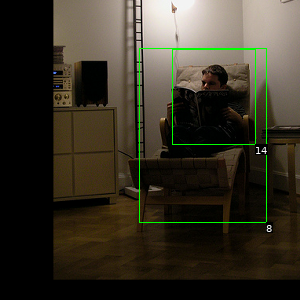

In [17]:
img, target = aug_val_ds[20]
print(img.shape, img.dtype, target[1].dtype, target[1])


vis_target = get_vis_tf_target(target)
vis_img = get_vis_image(img)


render_datapoint(vis_img, vis_target)

(3, 300, 300) float32
<class 'tuple'> 2 <class 'numpy.ndarray'> (2, 4) <class 'numpy.ndarray'>


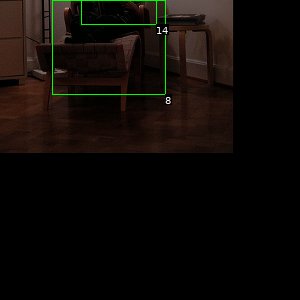

In [18]:
img, target = aug_val_ds[20]
print(img.shape, img.dtype)
print(type(target), len(target), type(target[0]), target[0].shape, type(target[1]))

vis_target = get_vis_tf_target(target)
vis_img = get_vis_image(img)


render_datapoint(vis_img, vis_target)

(3, 300, 300) float32
<class 'tuple'> 2 <class 'numpy.ndarray'> (1, 4) <class 'numpy.ndarray'>


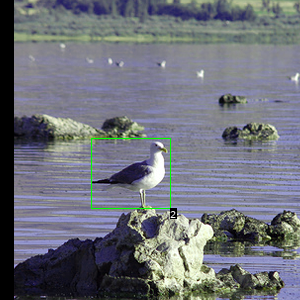

In [19]:
img, target = aug_train_ds[20]
print(img.shape, img.dtype)
print(type(target), len(target), type(target[0]), target[0].shape, type(target[1]))


vis_target = get_vis_tf_target(target)
vis_img = get_vis_image(img)


render_datapoint(vis_img, vis_target)

In [20]:
target

(array([[ 91.5767451 , 138.63331509, 170.73860817, 208.88946856]]), array([2]))

Model and BBox encoding

In [21]:
import torch

from models.rfbnet_vgg import RFBNetVGG
from models.multibox_coder import MultiboxCoder

In [22]:
def compute_grid_sizes(model, img_size):
    x = torch.rand(2, 3, img_size, img_size).to('cuda')  
    model = model.to('cuda')
    detection_inputs = model.forward_encoder(x)
    return [i.shape[-1] for i in detection_inputs]


model = RFBNetVGG(num_classes=len(VOC_CLASSES) + 1).to('cuda')
grid_sizes = compute_grid_sizes(model, 300)
grid_sizes

[37, 18, 9, 5, 3, 2, 1]

In [23]:
steps = (8, 16, 32, 64, 100, 150, 300)
sizes = (30, 60, 111, 162, 213, 264, 278, 315)

In [24]:
aspect_ratios = [(2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2,), (2,)]
variance = [0.1, 0.2]


coder = MultiboxCoder(grid_sizes, aspect_ratios, steps, sizes, variance)

# # Check encoding and decoding
# res = coder.encode(*target)
# conf = np.zeros((len(res[1]), len(VOC_CLASSES) + 1))
# for i, v in enumerate(res[1]):
#     conf[i, v] = 50.0
# decoded_target = coder.decode(res[0], conf)

In [25]:
# Number of anchors
sum([s * s * (len(a) * 2 + 2) for s, a in zip(grid_sizes, aspect_ratios)])

10868

In [26]:
def to_det(x, y):
    return x, coder.encode(*y)


det_aug_train_ds = TransformedDataset(aug_train_ds, xy_transform=to_det)
det_aug_val_ds = TransformedDataset(aug_val_ds, xy_transform=to_det)

Dataloaders

In [27]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(det_aug_train_ds, batch_size=8, shuffle=True, num_workers=8, drop_last=True)
val_dataloader = DataLoader(det_aug_val_ds, batch_size=8, shuffle=False, num_workers=8, drop_last=False)

In [28]:
# t = np.array([
# #     [ 92.53639943,   0.        , 199.03098169, 143.05239851],
#     [  0.        ,   0.        ,   0.        , 117.41481389],
# #     [  0.        ,   0.        ,   10.        , 117.41481389],
#     [  300.        ,   0.        ,   300.        , 117.41481389]
# ])
# l = np.array([4, 4])

# mb_bbox = t.copy()
# # (x_min, y_min, x_max, y_max) -> (x_min, y_min, width, height)
# mb_bbox[:, 2:] -= mb_bbox[:, :2]
# # (x_min, y_min, width, height) -> (center_x, center_y, width, height)
# mb_bbox[:, :2] += mb_bbox[:, 2:] / 2

# mb_bbox

# mask = (mb_bbox[:, 2:] > 0).all(axis=1)
# mb_bbox = mb_bbox[mask]

# len(mb_bbox)

In [29]:
for batch in train_dataloader:
    break

In [30]:
batch[1][0].shape, batch[1][1].shape

(torch.Size([8, 10868, 4]), torch.Size([8, 10868]))

In [31]:
batch[0].shape, batch[0].type()

(torch.Size([8, 3, 300, 300]), 'torch.FloatTensor')

In [32]:
x = batch[0].to('cuda')
y_pred = model(x)

In [33]:
y_pred[0].shape, y_pred[1].shape

(torch.Size([8, 10868, 4]), torch.Size([8, 10868, 21]))

Multibox Loss function

In [34]:
from losses.multibox_loss import multibox_loss

In [35]:
y = (batch[1][0].to('cuda'), batch[1][1].to('cuda'))

In [36]:
y[1].dtype, y_pred[1].dtype

(torch.int64, torch.float32)

In [38]:
res = multibox_loss(y_pred[0], y_pred[1], y[0], y[1], k=3)

In [39]:
res

(tensor(2.6241, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(15.0393, device='cuda:0', grad_fn=<DivBackward0>))

In [98]:
import torch.nn.functional as F

In [100]:
z = torch.zeros(())

z.type()

'torch.FloatTensor'

In [136]:
x = torch.rand(10, 100, 4).to('cuda')
y = torch.rand(10, 100, 4).to('cuda')

In [139]:
loss = F.smooth_l1_loss(x, y, reduction='none').sum(dim=-1)
loss.type(), loss.shape

('torch.cuda.FloatTensor', torch.Size([10, 100]))

In [286]:
l = torch.randint(0, 5, size=(8, 10))
positive = l > 3
n_positive = positive.sum().item()
n_positive

13

In [287]:
mb_confs = torch.rand(8, 10, 5)
gt_mb_labels = torch.randint(0, 5, size=(8, 10), dtype=torch.long)

conf_loss = F.cross_entropy(mb_confs.reshape(-1, mb_confs.shape[-1]), torch.flatten(gt_mb_labels), reduction='none').reshape(mb_confs.shape[0], -1)
conf_loss.shape

torch.Size([8, 10])

In [315]:
def _hard_negative(x, positive, k):
    _, idx = (x * (positive.type_as(x) - 1)).sort(dim=1)
    _, rank = idx.sort(dim=1)
    hard_negative = rank < (positive.sum(dim=1) * k)[:, None]
    return hard_negative

In [316]:
conf_loss

tensor([[2.0104, 1.6886, 1.7770, 1.6641, 1.8327, 1.7587, 1.5248, 1.3099, 1.8285,
         1.9997],
        [1.7438, 1.8618, 1.7029, 1.7833, 1.2575, 1.3874, 1.2056, 1.7728, 1.3227,
         1.1371],
        [1.3558, 1.7131, 1.6156, 1.6967, 1.9765, 1.8203, 1.5810, 1.6886, 1.2459,
         1.7026],
        [1.9155, 1.4637, 1.4607, 1.7282, 1.6974, 2.0984, 2.3134, 1.8817, 1.4211,
         1.2035],
        [2.0502, 1.4594, 2.0926, 1.3935, 1.5948, 1.7517, 1.3136, 1.8108, 1.1981,
         1.8640],
        [1.9819, 1.7312, 1.8312, 2.0566, 1.4792, 1.9517, 1.5710, 1.6051, 1.2698,
         1.3162],
        [1.1782, 1.4893, 1.6041, 1.2629, 1.5574, 1.6501, 1.7655, 1.5599, 1.8271,
         1.8447],
        [1.8128, 1.5463, 1.7194, 2.1120, 1.6196, 1.6839, 1.5875, 1.4693, 1.3343,
         1.7614]])

In [317]:
conf_loss * (positive.type(conf_loss.type()) - 1)

tensor([[-2.0104, -1.6886, -1.7770, -1.6641, -1.8327, -1.7587,  0.0000, -1.3099,
         -1.8285,  0.0000],
        [ 0.0000, -1.8618, -1.7029, -1.7833, -1.2575, -1.3874, -1.2056, -1.7728,
         -1.3227, -1.1371],
        [-1.3558, -1.7131, -1.6156, -1.6967,  0.0000, -1.8203, -1.5810, -1.6886,
         -1.2459, -1.7026],
        [-1.9155, -1.4637, -1.4607,  0.0000, -1.6974, -2.0984, -2.3134, -1.8817,
         -1.4211, -1.2035],
        [-2.0502, -1.4594, -2.0926,  0.0000, -1.5948,  0.0000, -1.3136, -1.8108,
          0.0000, -1.8640],
        [-1.9819, -1.7312, -1.8312, -2.0566, -1.4792, -1.9517, -1.5710, -1.6051,
          0.0000, -1.3162],
        [-1.1782, -1.4893, -1.6041, -1.2629, -1.5574, -1.6501,  0.0000, -1.5599,
         -1.8271, -1.8447],
        [-1.8128,  0.0000, -1.7194, -2.1120, -1.6196,  0.0000, -1.5875, -1.4693,
         -1.3343,  0.0000]])

In [322]:
hard_negative = _hard_negative(conf_loss, positive, 2)

In [323]:
conf_loss * (hard_negative).type(conf_loss.type())

tensor([[2.0104, 0.0000, 1.7770, 0.0000, 1.8327, 0.0000, 0.0000, 0.0000, 1.8285,
         0.0000],
        [0.0000, 1.8618, 0.0000, 1.7833, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.7131, 0.0000, 0.0000, 0.0000, 1.8203, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0984, 2.3134, 0.0000, 0.0000,
         0.0000],
        [2.0502, 1.4594, 2.0926, 0.0000, 1.5948, 0.0000, 0.0000, 1.8108, 0.0000,
         1.8640],
        [1.9819, 0.0000, 0.0000, 2.0566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8271,
         1.8447],
        [1.8128, 0.0000, 1.7194, 2.1120, 1.6196, 0.0000, 1.5875, 1.4693, 0.0000,
         0.0000]])

In [324]:
conf_loss * (positive | hard_negative).type_as(conf_loss)

tensor([[2.0104, 0.0000, 1.7770, 0.0000, 1.8327, 0.0000, 1.5248, 0.0000, 1.8285,
         1.9997],
        [1.7438, 1.8618, 0.0000, 1.7833, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.7131, 0.0000, 0.0000, 1.9765, 1.8203, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.7282, 0.0000, 2.0984, 2.3134, 0.0000, 0.0000,
         0.0000],
        [2.0502, 1.4594, 2.0926, 1.3935, 1.5948, 1.7517, 0.0000, 1.8108, 1.1981,
         1.8640],
        [1.9819, 0.0000, 0.0000, 2.0566, 0.0000, 0.0000, 0.0000, 0.0000, 1.2698,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.7655, 0.0000, 1.8271,
         1.8447],
        [1.8128, 1.5463, 1.7194, 2.1120, 1.6196, 1.6839, 1.5875, 1.4693, 0.0000,
         1.7614]])

Dataflow in sdd.pytorch

In [29]:
sys.path.insert(0, "../ssd.pytorch")

In [33]:
from data import *
from utils.augmentations import SSDAugmentation

In [35]:
cfg = voc
dataset = VOCDetection(root=voc_root_path.as_posix(),
                       transform=SSDAugmentation(cfg['min_dim'],
                                                 MEANS))


In [38]:
dp = dataset[0]
print(len(dp), type(dp[0]), type(dp[1]))
print(dp[0].shape, dp[1].shape)

2 <class 'torch.Tensor'> <class 'numpy.ndarray'>
torch.Size([3, 300, 300]) (3, 5)


In [43]:
dp = dataset[10]
print(len(dp), type(dp[0]), type(dp[1]))
print(dp[0].shape, dp[1].shape)

2 <class 'torch.Tensor'> <class 'numpy.ndarray'>
torch.Size([3, 300, 300]) (1, 5)


In [45]:
from torch.utils.data import DataLoader


data_loader = DataLoader(dataset, 4, num_workers=2, shuffle=True, collate_fn=detection_collate)

In [46]:
for batch in data_loader:
    break

In [55]:
print(type(batch[0]), batch[0].shape)
print(type(batch[1]), len(batch[1]), type(batch[1][0]))

for y in batch[1]:
    print(y.shape)

<class 'torch.Tensor'> torch.Size([4, 3, 300, 300])
<class 'list'> 4 <class 'torch.Tensor'>
torch.Size([1, 5])
torch.Size([2, 5])
torch.Size([5, 5])
torch.Size([1, 5])


Check original bbox encoding/decoding for SSD300

In [44]:
grid_sizes = (38, 19, 10, 5, 3, 1)
steps = (8, 16, 32, 64, 100, 300)
sizes = (30, 60, 111, 162, 213, 264, 315)
aspect_ratios = [(2,), (2, 3), (2, 3), (2, 3), (2,), (2,)]
variance = [0.1, 0.2]


coder = MultiboxCoder(grid_sizes, aspect_ratios, steps, sizes, variance)

res = coder.encode(*target)

conf = np.zeros((len(res[1]), len(VOC_CLASSES) + 1))
for i, v in enumerate(res[1]):
    conf[i, v] = 50.0

decoded_target = coder.decode(res[0], conf, nms_thresh=0.45, score_thresh=0.5)

print(target)
print(decoded_target)

Compare datapoint with RFBNet

In [2]:
import sys
sys.path.insert(0, "../../../../RFBNet")

In [22]:
from pathlib import Path
import os


here_path = Path(".").resolve()
os.environ["VOC_ROOT"] = "/home/storage_ext4_1tb/VOCdevkit/"

voc_root_var = "VOC_ROOT" if "VOC_ROOT" in os.environ else "VOC_DIR"
voc_root_path = Path(os.environ[voc_root_var])

assert voc_root_path.exists(), "Path '{}' is not found".format(voc_root_path)


from data import VOCDetection, preproc, AnnotationTransform


ds = VOCDetection(voc_root_path.as_posix(), image_sets=[('2012', 'trainval')], preproc=preproc(300, (0, 0, 0), 0.5), target_transform=AnnotationTransform())
len(ds)

11540

In [23]:
import matplotlib.pylab as plt

%matplotlib inline

In [24]:
img, target = ds[0]
type(img), type(target)

(torch.Tensor, numpy.ndarray)

In [25]:
import numpy as np 

from image_dataset_viz import render_datapoint, bbox_to_points


def get_vis_target(targets, w, h):
    
    out = []
    for t in target:
        bbox = t[0:4]
        bbox[0] *= w
        bbox[2] *= w
        bbox[1] *= h
        bbox[3] *= h        
        label = t[-1]
        out.append((bbox_to_points(bbox), "{}".format(label)))
    return out
    

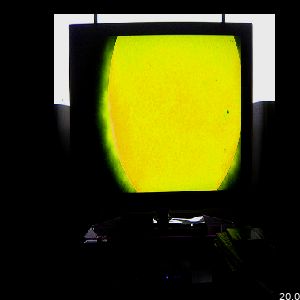

In [27]:
from image_dataset_viz import render_datapoint, bbox_to_points

np_img = img.numpy().transpose((1, 2, 0))[:, :, (1, 2, 0)].astype(np.uint8)
vis_target = get_vis_target(target, np_img.shape[1], np_img.shape[0])

# vis_target
render_datapoint(np_img, vis_target)